In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
!pip install tensorflow
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

In [ ]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('^ftse', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,5909.399902,5916.899902,5811.299805,5879.399902,5879.399902,689690000
1999-01-05,5882.299805,5980.500000,5875.799805,5958.200195,5958.200195,1033599000
1999-01-06,5968.899902,6157.399902,5968.899902,6148.799805,6148.799805,903848000
1999-01-07,6145.899902,6153.700195,6042.500000,6101.200195,6101.200195,650124000
1999-01-08,6115.399902,6195.600098,6114.799805,6147.200195,6147.200195,559612000


In [ ]:
end = '2024-03-30'
start = '2020-01-02'

testingData = yf.download('^ftse', start=start, end=end)
testingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,7542.399902,7624.799805,7542.399902,7604.299805,7604.299805,482206700
2020-01-03,7604.299805,7626.399902,7551.000000,7622.399902,7622.399902,475628900
2020-01-06,7622.399902,7622.399902,7528.100098,7575.299805,7575.299805,516783400
2020-01-07,7575.299805,7604.600098,7562.100098,7573.899902,7573.899902,511576100
2020-01-08,7573.899902,7579.500000,7525.000000,7574.899902,7574.899902,606225000


In [ ]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [ ]:
trainData


array([5879.39990234, 5958.20019531, 6148.79980469, ..., 7632.20019531,
       7644.89990234, 7587.10009766])

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [ ]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [ ]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=50,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    restore_best_weights=True
)


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_122 (LSTM)             (None, 20, 50)            10400     
                                                                 
 dropout_122 (Dropout)       (None, 20, 50)            0         
                                                                 
 lstm_123 (LSTM)             (None, 20, 50)            20200     
                                                                 
 dropout_123 (Dropout)       (None, 20, 50)            0         
                                                                 
 lstm_124 (LSTM)             (None, 20, 50)            20200     
                                                                 
 dropout_124 (Dropout)       (None, 20, 50)            0         
                                                                 
 lstm_125 (LSTM)             (None, 50)              

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

166/166 [==============================] - 10s 24ms/step - loss: 0.4059 - root_mean_squared_error: 0.6371 - mean_absolute_error: 0.5954


In [ ]:
len(xTrain)

5284

Epoch 1/100
31/31 [==============================] - 12s 138ms/step - loss: 0.0658 - root_mean_squared_error: 0.2564 - mean_absolute_error: 0.1808 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.0282
Epoch 2/100
31/31 [==============================] - 3s 111ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - mean_absolute_error: 0.0961 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893 - val_mean_absolute_error: 0.0814
Epoch 3/100
31/31 [==============================] - 3s 111ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - mean_absolute_error: 0.0877 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930 - val_mean_absolute_error: 0.0859
Epoch 4/100
31/31 [==============================] - 3s 103ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - mean_absolute_error: 0.0552 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.0349
Epoch 5/100
31/31 [==============================] 

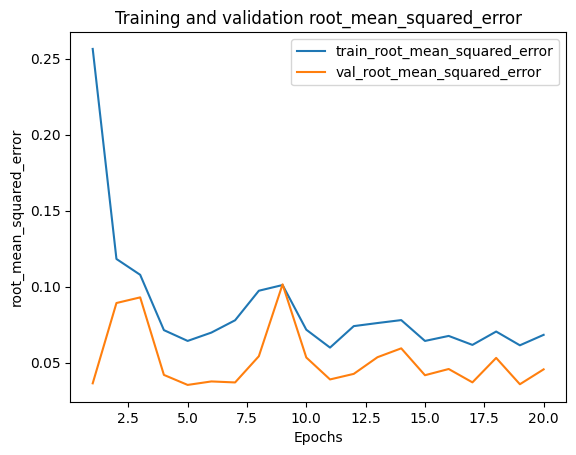

In [ ]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [ ]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))



In [ ]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 2s 15ms/step


0.07719862264430756

In [ ]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 1s 17ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - mean_absolute_error: 0.0484


In [ ]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [ ]:
df2

,Pred Adj Close
0,7587.130371
1,7583.349121
2,7577.093262
3,7570.066406
4,7560.921387
...,...
1045,7658.180664
1046,7662.425781
1047,7668.807617
1048,7676.806641


In [ ]:
df = df1.join(df2)
df = df.set_index('Date')

In [ ]:
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,7604.299805,7587.130371
2020-01-03,7622.399902,7583.349121
2020-01-06,7575.299805,7577.093262
2020-01-07,7573.899902,7570.066406
2020-01-08,7574.899902,7560.921387
...,...,...
2024-02-23,7706.299805,7658.180664
2024-02-26,7684.299805,7662.425781
2024-02-27,7683.000000,7668.807617


Results

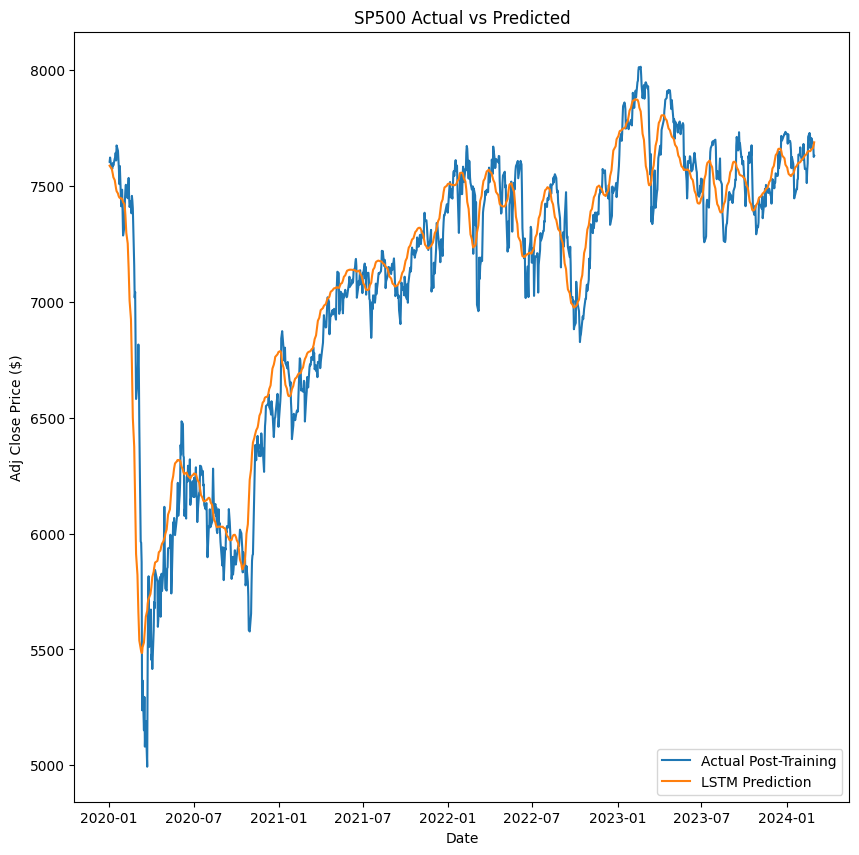

In [ ]:
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('FTSE Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(23):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=23, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)

1/1 [==============================] - 0s 29ms/step
            Predicted Adj Close
2024-03-29          7700.408691
2024-04-01          7712.003906
2024-04-02          7724.888672
2024-04-03          7736.797852
2024-04-04          7746.454590
2024-04-05          7754.188477
2024-04-08          7761.126465
2024-04-09          7765.933105
2024-04-10          7766.876953
2024-04-11          7765.963867
2024-04-12          7764.945312
2024-04-15          7763.528809
2024-04-16          7761.540527
2024-04-17          7758.584473
2024-04-18          7755.342773
2024-04-19          7747.927734
2024-04-22          7739.733887
2024-04-23          7732.690918
2024-04-24          7725.963379
2024-04-25          7719.892090
2024-04-26          7713.853516
2024-04-29          7715.367676
2024-04-30          7715.907227


In [ ]:
predicted_df

,Predicted Adj Close
2024-03-29,7700.408691
2024-04-01,7712.003906
2024-04-02,7724.888672
2024-04-03,7736.797852
2024-04-04,7746.454590
2024-04-05,7754.188477
2024-04-08,7761.126465
2024-04-09,7765.933105
2024-04-10,7766.876953
2024-04-11,7765.963867


In [ ]:
train_predictions = model.predict(xTrain)
train_predictions = sc.inverse_transform(train_predictions)


166/166 [==============================] - 2s 15ms/step


In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))
plt.title('FTSE 100 Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')

# Since xTrain doesn't include the first 'n_steps' data points, adjust the index accordingly for plotting
adjusted_dates = trainingData.index[n_steps:]

plt.plot(adjusted_dates, trainData[n_steps:], label='Actual Training Data', color='blue')
plt.plot(adjusted_dates, train_predictions.flatten(), label='Predicted Training Data', color='orange')

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()